In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud
from src.progress_bar import printProgressBar
from ast import literal_eval

for dirname, _, filenames in os.walk('../../data/lyrics'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\", "/"))

print(50 * '-')

for dirname, _, filenames in os.walk('../../data/billboard'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\", "/"))


../../data/lyrics/BB-L-EN.csv
../../data/lyrics/BB-L.csv
../../data/lyrics/BB-L_invalid.json
../../data/lyrics/BB-L_invalid_updated.csv
../../data/lyrics/BB-L_raw.csv
../../data/lyrics/covid_lyrics_bb.csv
../../data/lyrics/N-BB-L-EN.csv
../../data/lyrics/N-BB-L.csv
../../data/lyrics/N-BB-L_invalid.json
../../data/lyrics/N-BB-L_invalid_updated.csv
../../data/lyrics/N-BB-L_raw.csv
../../data/lyrics/backups/artist_song_lyrics_bak.csv
../../data/lyrics/backups/bb-t100-lyrics.csv
../../data/lyrics/backups/bb-t100-lyrics_new.csv
../../data/lyrics/backups/bb-t100-lyrics_old.csv
../../data/lyrics/backups/bb_t100_lyrics_en.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v1.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v2.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v3.csv
../../data/lyrics/backups/corona-lyrics.csv
../../data/lyrics/backups/lyrics_invalid_updated.csv
--------------------------------------------------
../../data/billboard/BB-T100-EN.csv
../../data/billboard/BB-T100.csv
../.

### Import Lyrics

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 30)
bb_l_en = pd.read_csv('../../data/lyrics/BB-L-EN.csv', index_col=0, encoding='utf-8')
bb_l_en['genius_annotations'] = bb_l_en['genius_annotations'].apply(literal_eval)
bb_l_en['genius_comments'] = bb_l_en['genius_comments'].apply(literal_eval)
bb_l_en.tail()

,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,url,length,word_count,language,language_score,first_appearance,genius_primary_artist,genius_description,genius_annotations,genius_comments,release_date
1317,10459,1317,Eminem,Eminem,Gnat,1.0,60.0,6285862,"Yeah, yeah, sick\r\n(d.a. ...",https://genius.com/Eminem-...,5762,1113,en,0.999999,2021-01-02,Eminem,"On “Gnat,” the third promo...","[(With the dope, I’m an OG...","[THIS IS THE COVID DISS, T...",2020-12-18
1318,10477,1318,Gabby Barrett,Gabby Barrett,The First Noel,1.0,78.0,6086107,"The First Noel, the Angels...",https://genius.com/Gabby-b...,666,132,en,0.999996,2021-01-02,Gabby Barrett,?,[],[],2020-10-23
1319,10483,1319,Popp Hunna,Popp Hunna,Adderall (Corvette Corvette),1.0,84.0,6110220,"(Bitch)\r\nCorvette, Corve...",https://genius.com/Popp-hu...,2366,515,en,0.999998,2021-01-02,Popp Hunna,Adderall (Corvette Corvett...,[(Didn’t even think it cou...,"[It’s the [?] for me, this...",2020-10-15
1320,10492,1320,Lil Durk,Lil Durk,Backdoor,1.0,93.0,6270159,(Malik on the beat)\r\n(Ay...,https://genius.com/Lil-dur...,2778,547,en,0.999996,2021-01-02,Lil Durk,Lil Durk returns to the mu...,[((Oh)\n Close that backdo...,"[#LLVON🕊🕊, R.I.P von ❤🕊, L...",2020-12-21
1321,10497,1321,DDG,DDG,Moonwalking In Calabasas,1.0,98.0,5800223,Ballin' since I was a jit\...,https://genius.com/Ddg-moo...,2786,549,en,0.999996,2021-01-02,DDG,“Moonwalking in Calabasas”...,"[(She off X, she sleepy, s...",[DDG should have 10times h...,2020-07-25


### Import Billboard Data

In [3]:
bb_t100 = pd.read_csv('../../data/billboard/BB-T100-EN.csv', index_col=0)
bb_t100.head()

,billboard_id,lyrics_id,song,artist,peak_rank,rank_last_week,weeks_on_chart,rank,date,first_appearance,language,language_score
0,0,0,"Thank U, Next",Ariana Grande,1,1,8,1,2019-01-05,2019-01-05,en,0.999997
1,1,1,Without Me,Halsey,2,2,12,2,2019-01-05,2019-01-05,en,0.999995
2,2,2,All I Want For Christmas I...,Mariah Carey,3,7,30,3,2019-01-05,2019-01-05,en,0.999996
3,3,3,Sicko Mode,Travis Scott,1,3,21,4,2019-01-05,2019-01-05,en,0.999998
4,4,4,Sunflower (Spider-Man: Int...,Post Malone & Swae Lee,4,4,10,5,2019-01-05,2019-01-05,en,0.999997


### Keyword Extraction

In [4]:
import spacy

nlp = spacy.load("en_core_web_lg")
nlp.Defaults.stop_words |= {'ai', 'gon'}

In [5]:
import re


#inspired by: https://betterprogramming.pub/extract-keywords-using-spacy-in-python-4a8415478fbf
def get_keywords(text, nlp):
    text = re.sub(u'[^\\x00-\\x7F\\x80-\\xFF\\u0100-\\u017F\\u0180-\\u024F\\u1E00-\\u1EFF]', u'', text)
    doc = nlp(text)
    keywords = {}
    pos_tag = ['NOUN', 'ADJ', 'PROPN', 'VERB']
    for token in doc:
        if token.is_stop or token.is_punct:
            continue

        if token.pos_ in pos_tag:
            if token.lemma_ not in nlp.Defaults.stop_words:
                keyword = token.lemma_.lower()
            else:
                continue

            if keyword in keywords.keys():
                keywords[keyword] += 1
            else:
                keywords[keyword] = 1

    return dict(sorted(keywords.items(), key=lambda item: item[1], reverse=True))


Keywords are cached to speed up future iterations of this notebook.

In [6]:
try:
    keywords = pd.read_csv('../../data/cache/keywords.csv', index_col=0)
    keywords['keywords'] = keywords['keywords'].apply(literal_eval)
    desc_keywords = pd.read_csv('../../data/cache/desc_keywords.csv', index_col=0)
    desc_keywords['desc_keywords'] = desc_keywords['desc_keywords'].apply(literal_eval)
    ann_keywords = pd.read_csv('../../data/cache/ann_keywords.csv', index_col=0)
    ann_keywords['ann_keywords'] = ann_keywords['ann_keywords'].apply(literal_eval)
    com_keywords = pd.read_csv('../../data/cache/com_keywords.csv', index_col=0)
    com_keywords['com_keywords'] = com_keywords['com_keywords'].apply(literal_eval)
except FileNotFoundError:
    bb_l_en_series = bb_l_en['lyrics']
    keywords = []
    desc_series = bb_l_en['genius_description']
    desc_keywords = []
    ann_series = bb_l_en['genius_annotations']
    ann_keywords = []
    com_series = bb_l_en['genius_comments']
    com_keywords = []
    i = 0
    l = len(bb_l_en_series)
    printProgressBar(0, l, prefix='Progress:', suffix='Complete', length=50)
    for i in range(0, l):
        keywords.append(get_keywords(bb_l_en_series.iloc[i], nlp))
        desc_keywords.append(get_keywords(str(desc_series.iloc[i]), nlp))
        annotations = ' '.join(ann[1][0][0] for ann in bb_l_en['genius_annotations'].iloc[i])
        ann_keywords.append(get_keywords(annotations, nlp))
        comments = ' '.join(bb_l_en['genius_comments'].iloc[i])
        com_keywords.append(get_keywords(comments, nlp))
        printProgressBar(i, l, prefix='Progress:', suffix='Complete', length=50)

bb_l_en['keywords'] = keywords
bb_l_en['keywords'].to_csv('../../data/cache/keywords.csv')
bb_l_en['desc_keywords'] = desc_keywords
bb_l_en['desc_keywords'].to_csv('../../data/cache/desc_keywords.csv')
bb_l_en['ann_keywords'] = ann_keywords
bb_l_en['ann_keywords'].to_csv('../../data/cache/ann_keywords.csv')
bb_l_en['com_keywords'] = com_keywords
bb_l_en['com_keywords'].to_csv('../../data/cache/com_keywords.csv')


generate collumns for top 5 keywords

In [7]:
def get_top_keyword(keywords, pos):
    if len(keywords) > 0 and pos < len(keywords):
        return list(keywords)[pos]
    else:
        return ''


bb_l_en['keyword_1'] = bb_l_en['keywords'].apply(lambda keywords: get_top_keyword(keywords, 0))
bb_l_en['keyword_2'] = bb_l_en['keywords'].apply(lambda keywords: get_top_keyword(keywords, 1))
bb_l_en['keyword_3'] = bb_l_en['keywords'].apply(lambda keywords: get_top_keyword(keywords, 2))
bb_l_en['keyword_4'] = bb_l_en['keywords'].apply(lambda keywords: get_top_keyword(keywords, 3))
bb_l_en['keyword_5'] = bb_l_en['keywords'].apply(lambda keywords: get_top_keyword(keywords, 4))

bb_l_en.sort_values(by='keyword_1').head()

,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,genius_id,lyrics,url,...,release_date,keywords,desc_keywords,ann_keywords,com_keywords,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5
1308,10399,1308,Kid Cudi,Kid Cudi,Beautiful Trip,1.0,100.0,6250761,"Oh, oh\r\nOh\r\nThree (Thr...",https://genius.com/Kid-cud...,...,2020-12-11,{},"{'short': 2, 'intro': 2, '...","{'track': 4, 'moon': 4, 't...","{'intro': 7, 'album': 4, '...",,,,,
762,6263,762,Lil Baby Featuring Lil Wayne,Lil Baby,Forever,1.0,64.0,4586489,Who made this beat?\r\nTwy...,https://genius.com/Lil-bab...,...,2020-02-28,"{'active': 10, 'nigga': 7,...","{'lil': 2, 'baby': 2, 'off...","{'baby': 6, 'track': 4, 's...","{'wayne': 5, 'goat': 3, 'h...",active,nigga,know,let,sell
198,973,198,Gunna Featuring Young Thug,Gunna,3 Headed Snake,1.0,74.0,4328174,"Aimin' at a date, aimin' a...",https://genius.com/Gunna-3...,...,2019-02-22,"{'aimin': 24, 'wraith': 10...","{'gunna': 2, 'young': 2, '...","{'young': 12, 'thug': 10, ...","{'gunna': 5, 'gator': 3, '...",aimin,wraith,gate,fuck,shit
1030,8113,1030,Juice WRLD,Juice WRLD,Titanic,2.0,14.0,5751445,DY definitely Krazy\r\n\r\...,https://genius.com/Juice-w...,...,2020-07-10,"{'air': 13, 'midnight': 10...","{'track': 3, 'juice': 2, '...","{'juice': 18, 'song': 8, '...","{'album': 4, 'good': 4, 'j...",air,midnight,titanic,fuck,good
484,3736,484,Post Malone,Post Malone,Allergic,2.0,37.0,4839337,Wasted on Sunday\r\nErase ...,https://genius.com/Post-ma...,...,2019-09-06,"{'allergic': 8, 'sad': 5, ...","{'post': 3, 'verse': 2, 't...","{'substance': 2, 'result':...","{'song': 4, 'album': 3, 'f...",allergic,sad,true,bad,feel


get keywords for 2019

In [9]:
bb_t100['date'] = pd.to_datetime(bb_t100['date'], format='%Y-%m-%d')
bb_t100['year'] = bb_t100['date'].apply(lambda date: date.year)
ids2019 = bb_t100['lyrics_id'].loc[bb_t100['year'] == 2019].unique()
ids2020 = bb_t100['lyrics_id'].loc[bb_t100['year'] == 2020].unique()


In [10]:
keywords_2019_pt = pd.pivot_table(bb_l_en.loc[ids2019], index=['keyword_1'],
                                  values=['lyrics_id'],
                                  aggfunc={'lyrics_id': 'count'})
keywords_2019_pt.sort_values(by='lyrics_id', inplace=True, ascending=False)
keywords_2019_pt

,lyrics_id
keyword_1,
nigga,30
love,27
know,23
want,20
bitch,17
let,11
wanna,10
need,9
time,9


In [11]:
keywords_2019_dict = {}
for row in keywords_2019_pt.itertuples():
    keywords_2019_dict[row[0]] = row[1]

#keywords_2019_dict


generate wordcloud

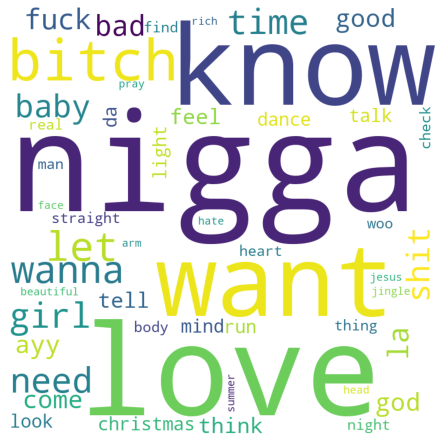

In [12]:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white', relative_scaling=0.80,
                      max_words=50).fit_words(keywords_2019_dict)

# plot the WordCloud image
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
wordcloud.to_file('../../data/output/figures/top_words_2019.jpg')
plt.show()


get keywords for 2020

In [13]:
keywords_2020_pt = pd.pivot_table(bb_l_en.loc[ids2020], index=['keyword_1'],
                                  values=['lyrics_id'],
                                  aggfunc={'lyrics_id': 'count'})
keywords_2020_pt.sort_values(by='lyrics_id', inplace=True, ascending=False)
keywords_2020_pt

,lyrics_id
keyword_1,
know,59
nigga,51
bitch,30
love,27
want,18
ayy,13
time,12
girl,10
shit,10


In [14]:
keywords_2020_dict = {}
for row in keywords_2020_pt.itertuples():
    keywords_2020_dict[row[0]] = row[1]

#keywords_2020_dict


generate wordcloud

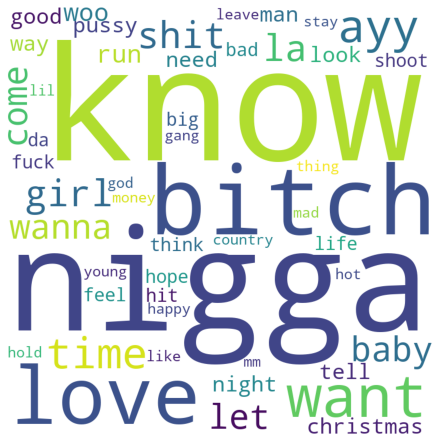

In [15]:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white', relative_scaling=0.80,
                      max_words=50).fit_words(keywords_2020_dict)

# plot the WordCloud image
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
wordcloud.to_file('../../data/output/figures/top_words_2020.eps')
plt.show()

### COVID-19 Songs

In [16]:

covid_ids = bb_l_en['lyrics_id'].loc[bb_l_en['release_date'] >= '2020-03-01'].unique()
missing_release_dates = bb_l_en['lyrics_id'].loc[bb_l_en['release_date'].isna()].unique()
for lyrics_id in missing_release_dates:
    if bb_l_en['first_appearance'].loc[lyrics_id] >= '2020-03-01':
        covid_ids = np.append(covid_ids, lyrics_id)

covid_ids = list(set(covid_ids))

In [17]:
# covid_keywords = ['antidote', 'contact', 'contracting', 'corona', 'coronavirus', 'cough', 'covid', 'cure',
#                    'distancing', 'flu', 'hazmat', 'hospitable', 'ill', 'mask', 'pandemic', 'quarantine', 'sars',
#                    'sick', 'solitary', 'symptom', 'threat', 'virus', 'wave']

# covid_keywords = ['antidote', 'contracting', 'corona', 'coronavirus', 'cough', 'covid', 'distancing', 'flu', 'hazmat',
#                    'hospitable', 'mask', 'pandemic', 'quarantine', 'sars', 'symptom', 'virus']

covid_keywords = ['corona', 'coronavirus', 'covid', 'pandemic', 'quarantine', 'sars', 'virus']


def has_covid_keyword(keywords):
    for word in covid_keywords:
        if word in keywords:
            return True
    return False


export covid lyrics

In [18]:
bb_l_en['has_covid_keyword'] = bb_l_en['keywords'].apply(has_covid_keyword)
bb_l_en['desc_has_covid_keyword'] = bb_l_en['desc_keywords'].apply(has_covid_keyword)
bb_l_en['ann_has_covid_keyword'] = bb_l_en['ann_keywords'].apply(has_covid_keyword)
bb_l_en['com_has_covid_keyword'] = bb_l_en['com_keywords'].apply(has_covid_keyword)
covid_lyrics = bb_l_en.loc[covid_ids].loc[(bb_l_en['has_covid_keyword'] == True) |
                                         (bb_l_en['desc_has_covid_keyword'] == True) |
                                         (bb_l_en['ann_has_covid_keyword'] == True)]
covid_lyrics.to_excel('../../data/output/covid_lyrics_bb.xlsx', encoding='utf-8')
covid_lyrics.to_csv('../../data/lyrics/covid_lyrics_bb.csv', encoding='utf-8')


get covid keywords

In [19]:
covid_keywords = {}
for keywords in covid_lyrics['keywords']:
    for keyword in keywords:
        if keyword in covid_keywords.keys():
            covid_keywords[keyword] += keywords[keyword]
        else:
            covid_keywords[keyword] = keywords[keyword]

covid_keywords = dict(sorted(covid_keywords.items(), key=lambda item: item[1], reverse=True))

generate wordcloud

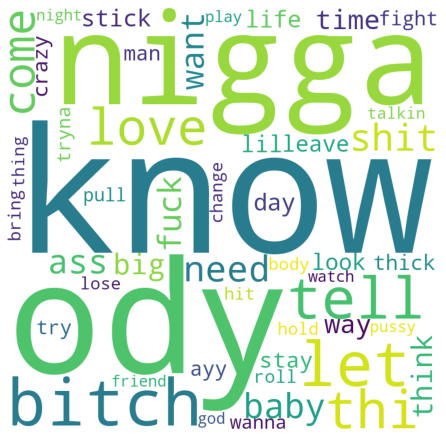

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=800,
                      background_color='white', relative_scaling=0.80,
                      max_words=50).fit_words(covid_keywords)

# plot the WordCloud image
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
wordcloud.to_file('../../data/output/figures/top_words_cov.eps')
plt.show()

In [21]:
covid_lyrics.shape

(46, 33)